# Setup

**Imports**

In [41]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.signal import chirp, stft, sweep_poly

from collections import Counter
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import scipy
from ruptures.base import BaseCost
import contextily as cx
from kneed import KneeLocator


rng = np.random.default_rng()

**Utility functions**

In [21]:
tones = {"1": (697, 1209), "2": (697, 1336), "3": (697, 1477), "4": (770, 1209), "5": (770, 1336), "6": (770, 1477), "7": (852, 1209), "8": (852, 1336), "9": (852, 1477), "0": (941, 1336), "*": (941, 1209), "#": (941, 1477), "A": (697, 1633), "B": (770, 1633), "C": (852, 1633), "D": (941, 1633)}
FS = 22_050  # Hz
sigma = 2


def generate_symbol(symbol, duration, fs):
    """Generate the sound for number with given duration"""
    # get both frequencies for the symbol
    f1, f2 = tones[symbol]
    # time array
    time_arr = np.arange(0, duration, 1 / fs)
    # audio signal
    signal = np.cos(2 * np.pi * f1 * time_arr) + np.cos(2 * np.pi * f2 * time_arr)
    return signal

def generate_signal():
    n_symbols = rng.integers(3, 12)
    list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)

    list_of_segments = list()

    for symbol in list_of_symbols:
        duration = rng.uniform(low=0.05, high=0.2)  # seconds
        # generate tone
        symbol_signal = generate_symbol(symbol=symbol, duration=duration, fs=FS)
        # generate silence
        silence = np.zeros(int(duration*FS))
        # append tone and silence
        list_of_segments.extend([symbol_signal, silence])

    # silence at the start
    silence = np.zeros(int(duration*FS))
    list_of_segments = [silence] + list_of_segments

    signal = np.concatenate(list_of_segments)
    n_samples = signal.shape[0]
    time_array = np.arange(n_samples) / FS
    
    # add nuissance
    inst_freq = np.sin(2 * np.pi * 1.2 * time_array) * 1500 + 2000
    poly = np.polyfit(x=time_array, y=inst_freq, deg=14)
    sin_freq = sweep_poly(time_array, poly)
    signal += sin_freq
    # add white noise
    signal += rng.normal(scale=sigma, size=n_samples)

    return signal, list_of_symbols.tolist()

# Question 1


[Dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) is a procedure to encode symbols using audio signal.

A symbold is represented by a sum of cosine waves: for $t=0,1,\dots,T-1$,

$$
y_t = \cos(2\pi f_1 t/f_s) + \cos(2\pi f_2 t/f_s)
$$
where each combination of $(f_1, f_2)$ represents a symbols (see table below).


|         | 1209 Hz  | 1336 Hz  | 1477 Hz  | 1633 Hz  |
|---------|----------|----------|----------|----------|
| **697 Hz**  | 1        | 2        | 3        | A        |
| **770 Hz**  | 4        | 5        | 6        | B        |
| **852 Hz**  | 7        | 8        | 9        | C        |
| **941 Hz**  | *        | 0        | #        | D        |

In [24]:
signal, symbols = generate_signal()
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

A 0 * 3 *


In [29]:
class MultivariateNormalCost(BaseCost):
    
    """Custom cost for piecewise Poisson signals."""

    # The 2 following attributes must be specified for compatibility.
    model = "Poisson"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        subsignal = self.signal[start:end]
        cov_mat = np.cov(subsignal.T)
        _, val = np.linalg.slogdet(cov_mat)
        return (end-start)*val

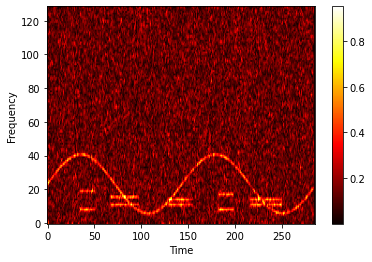

In [38]:
from scipy.signal import stft

f, t, Zxx = stft(signal, FS, nperseg=256)

plt.figure()
plt.imshow(np.abs(Zxx), aspect='auto', cmap='hot', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

In [52]:
signal_freq = np.abs(Zxx.T)
cost = MultivariateNormalCost()
cost.fit(signal_freq)
errors = []
brkpts = [i for i in range(1, 50)]

for n in tqdm(brkpts):
    error = 0
    signal_freq = np.abs(Zxx.T)
    opt = rpt.Dynp(jump=5, min_size=5, model="l2", custom_cost=MultivariateNormalCost())
    predicted_bkps = opt.fit_predict(signal=signal_freq, n_bkps=n)
    for i in range(n):
        error += cost.error(predicted_bkps[i], predicted_bkps[i+1])
    errors.append(error)

100%|██████████| 49/49 [00:25<00:00,  1.92it/s]


No handles with labels found to put in legend.


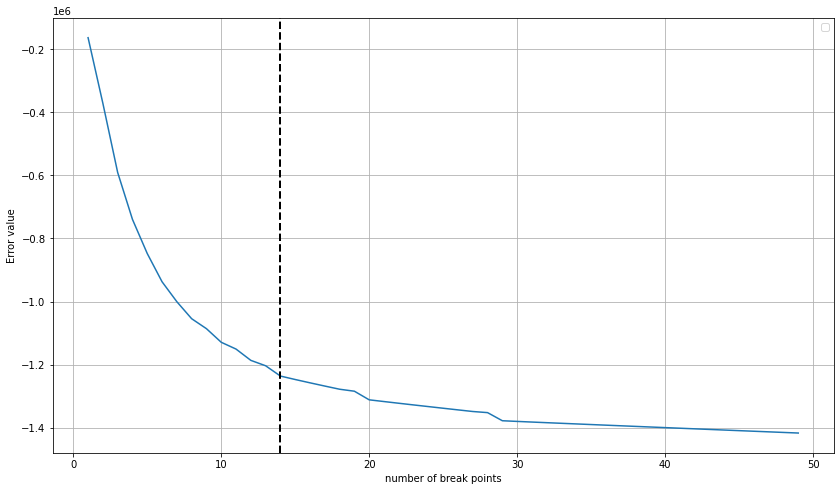

The best break point is : 14


In [54]:
knee = KneeLocator(brkpts, errors, curve='convex', direction='decreasing')
elbow = knee.knee

plt.figure(figsize = (14,8))
plt.plot(brkpts, errors)
plt.axvline(elbow, color = 'k', linestyle='--', linewidth=2 )
plt.legend()
plt.xlabel('number of break points')
plt.ylabel('Error value')
plt.grid()

plt.show()

print(f'The best break point is : {brkpts.index(elbow) + 1}')

# Question 2

In [3]:
sound_1 = np.loadtxt("signal_1.csv")
sound_2 = np.loadtxt("signal_2.csv")

# Question 3

In [2]:
def g_m(lambd, R, m, lambdn = 12, M = 9): 
  a = lambdn / (M + 1 - R)
  return g_u(lambd - a*m, R, a, lambdn = 12, M = 9)

def g_u(lambd, R, a, lambdn = 12, M = 9):
  if (lambd < 0) and (lambd >= -R*a):
    return  0.5 * (1 + np.cos(2*np.pi*(lambd/(a*R) + 0.5)))
  else:
    return 0 

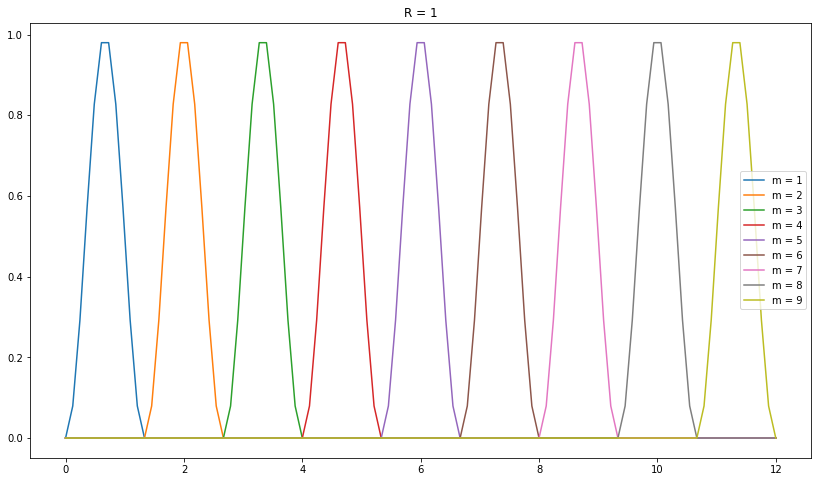

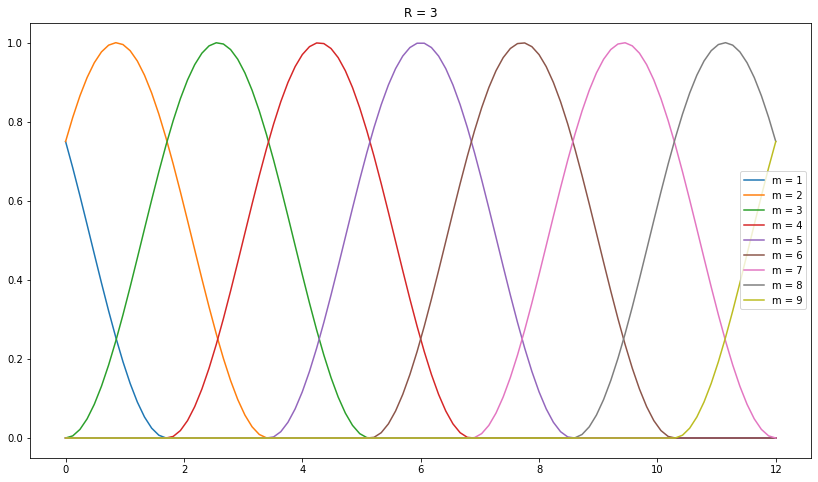

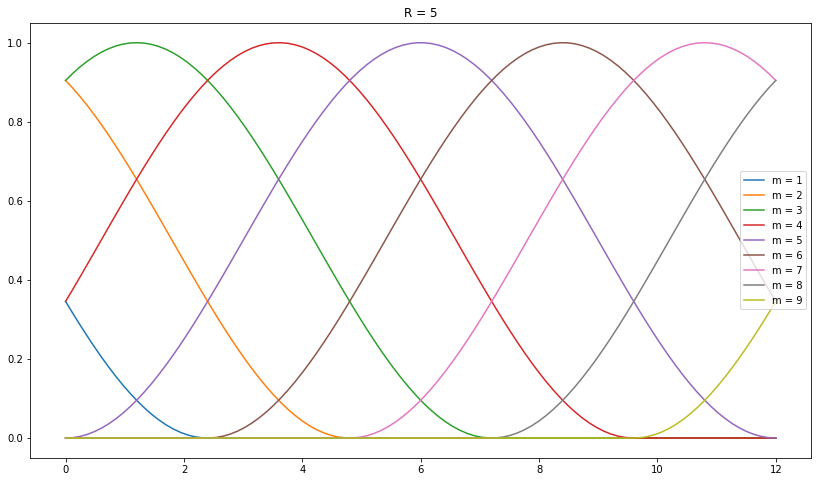

In [3]:
# Let's define the parameters and plot the graphs
M = 9 
lambd = 12
Rs = [1, 3, 5] 
lambdas = np.linspace(0,lambd,100)

# Plot the kernel functions

for i in range(len(Rs)):
    plt.figure(figsize = (14, 8))

    for m in range(1,M+1) :
        gm = []
        for x in lambdas : 
            gm.append(g_m(x, Rs[i], m))
        plt.plot(lambdas, gm, label='m = ' + str(m))
    plt.legend()
    plt.title('R = '+str( Rs[i]))
    plt.show()

# Question 4

In [4]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
import geopandas
from scipy.spatial.distance import pdist, squareform
from math import asin, cos, radians, sin, sqrt
from pygsp import graphs

In [5]:
# Load temperature data 
data_df, stations_df, description = load_molene_meteo_dataset()

# Convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius as in tutorial

temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


### Remove all stations with missing values in the temperature

In [6]:
# Compute number of missing values 

missing_vals = temperature_df.isna().sum()
print(f"The number of station to remove is {sum(np.where(temperature_df.isna().sum() >0, 1, 0))}")
# Now let's remove them 
temp = temperature_df.isna().sum(axis=0).sort_values(ascending=False)
columns_to_drop = temp.index[temp > 0]
columns_to_keep = temp.index[temp ==  0]

The number of station to remove is 18


In [7]:
temperature_df = temperature_df[columns_to_keep]
stations_df = stations_df[stations_df['Nom'].isin(columns_to_keep)]

### choose the minimum threshold so that the network is connected and the average degree is at least 3

In [8]:
CRS = "EPSG:4326"

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

# Convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry= geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

The average degree =  3.66

The threshold is 0.83


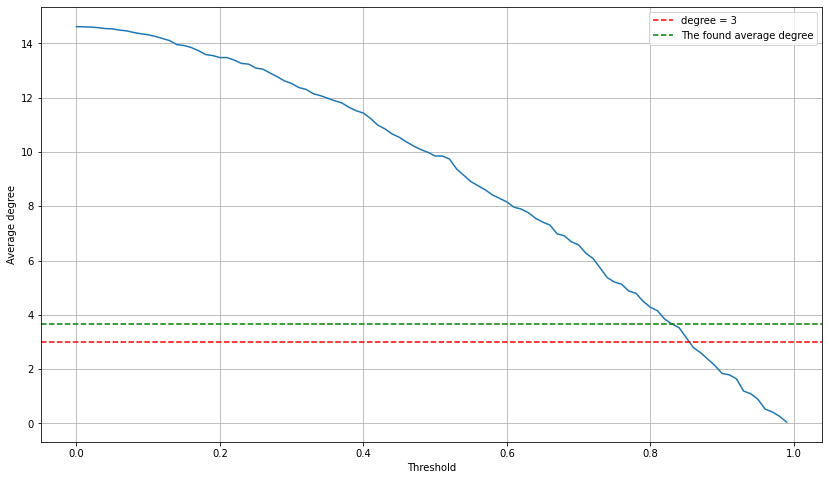

In [9]:
# Median Heuristic
sigma = np.median(dist_mat_condensed) 

thresholds = np.arange(0,1,0.01)

avg_degrees=[]

for threshold in thresholds : 
  # Adjacency matrix
  adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))

  # Average degree 
  avg_degrees.append(np.mean(adjacency_matrix_gaussian.sum(axis=1)))

# Compute the minimum threshold 
for threshold in thresholds[::-1] : 
  adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
  G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
  average_degree = np.mean(adjacency_matrix_gaussian.sum(axis=1))
  if G_gaussian.is_connected(recompute=True) and average_degree >= 3 :
    print(f"The average degree =  {round(average_degree,2)}")
    print()
    print(f"The threshold is {round(threshold,2)}")
    break

# Visualization

plt.figure(figsize = (14, 8))
plt.plot(thresholds,avg_degrees)
plt.axhline(y=3,color = 'red', linestyle='--', label = "degree = 3")
plt.axhline(y= average_degree ,color = 'green', linestyle='--', label = "The found average degree")
plt.legend()
plt.ylabel('Average degree')
plt.xlabel('Threshold')
plt.grid(True)
plt.show()



### The time where the signal is the least / the most smooth 

In [10]:
# Compute the Laplacian matrix 
laplacian_matrix = G_gaussian.L.todense()

# Compute the smoothness 
smoothness = []

for date in temperature_df.index:
  signal = temperature_df.loc[date].to_numpy()
  smoothness.append(float(signal.T.dot(laplacian_matrix).dot(signal))) # compute the smoothness index

print(f"Time where the signal is the smoothest: {temperature_df.index[np.argmin(smoothness)]}")
print(f"Time where the signal is the least smooth: {temperature_df.index[np.argmax(smoothness)]}")

Time where the signal is the smoothest: 2014-01-24 19:00:00
Time where the signal is the least smooth: 2014-01-21 06:00:00


# Question 5

In [13]:
def classify_nodes(index, return_labels = False, plot = True):
  """
  Classify and display the nodes in a given signal

  """
  signal = temperature_df.loc[temperature_df.index[index]].to_numpy()

  threshold = 0.83

  M = 9
  R = 3

  # Eigenvalues and eigenvectors of the Laplacian 

  adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
  G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
  laplacian_matrix = G_gaussian.L.todense()
  eigenval, eigenvec = scipy.linalg.eig(laplacian_matrix)
  eigenval = np.real(eigenval)

  eigenvec = eigenvec.T

  # Now let's sort the eigenvalues 
  sorted_index = eigenval.argsort()
  eigenval = eigenval[sorted_index]
  eigenvec = eigenvec[sorted_index]

  # Graph Fourier Transform (GFT)
  signal_hat = eigenvec @ signal
  
  labels = []
  for v in range(len(signal)):
    W_f =[]
    for m in range(1,M+1):
      W = 0
      for i in range(len(eigenval)) :
        W += g_m(eigenval[i], R, m, lambdn=eigenval[-1]) * signal_hat[i] * eigenvec[i, v]
      W_f.append(W)
    
    # Classify nodes into low/medium/high frequency
    val = [sum(np.abs(W_f[:3])**2),sum(np.abs(W_f[3:6])**2),sum(np.abs(W_f[6:])**2)]
    labels.append(np.argmax(val))

  # Display the results
  if plot :
    ax = stations_gdf.geometry.plot(figsize=(14, 8))
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    G_gaussian.set_coordinates(stations_np)
    G_gaussian.plot_signal(np.array(labels), ax=ax)
    _ = ax.set_title(f"Measures on the {temperature_df.index[index]}.")
    
  if return_labels:
    return labels

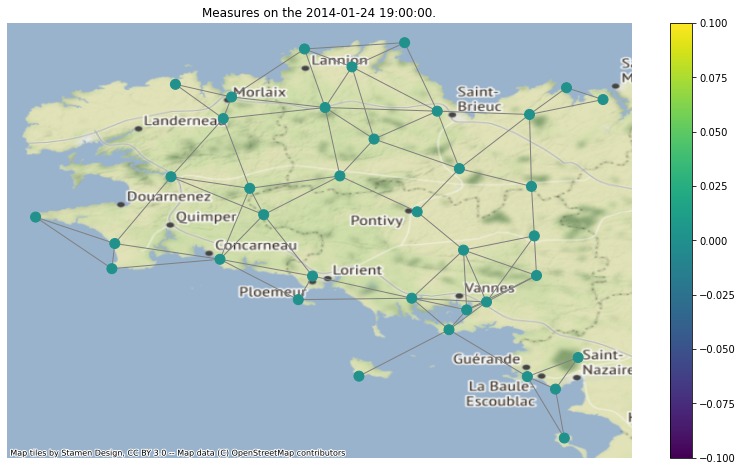

In [13]:
# Plotting the smoothest signal
classify_nodes(np.argmin(smoothness))

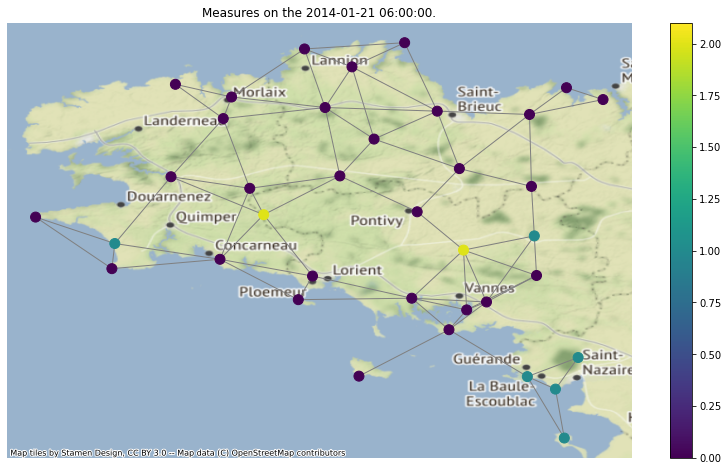

In [14]:
# Plotting the least smooth signal
classify_nodes(np.argmax(smoothness))

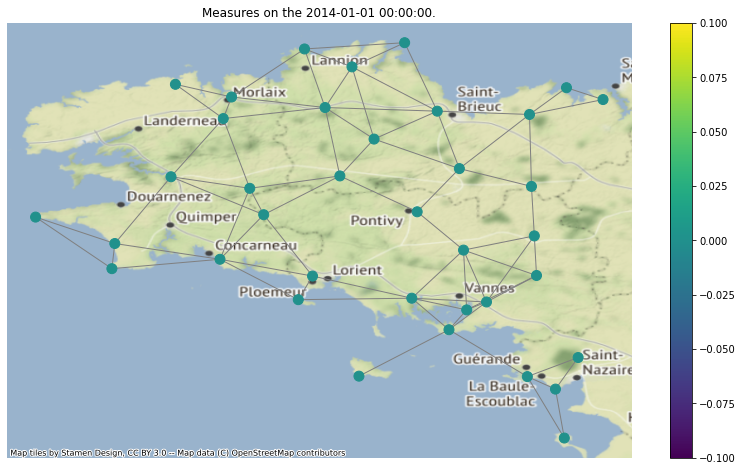

In [15]:
# Plotting the first available timestamp signal 
classify_nodes(0)

# Question 6

In [10]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

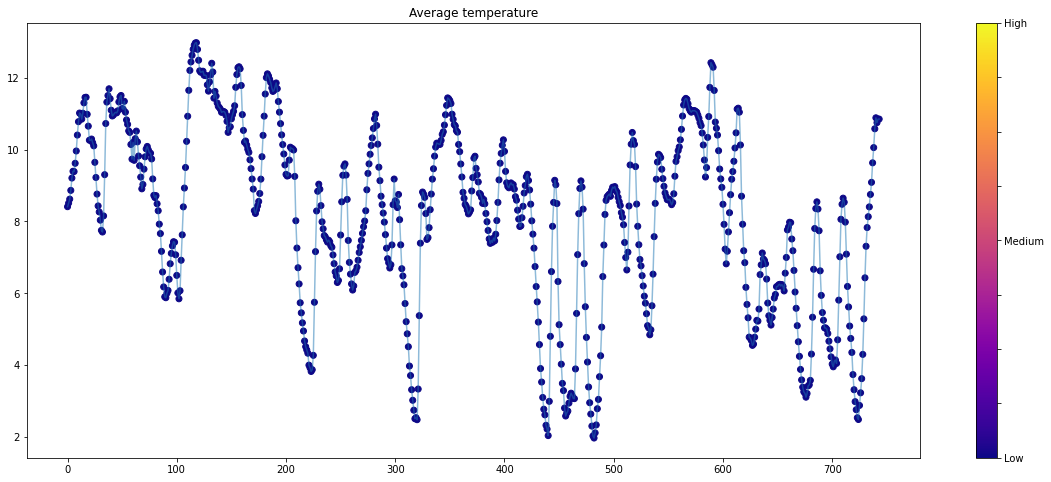

In [15]:
# Compute the average temperature
y = temperature_df.mean(axis=1)
x = np.arange(y.shape[0])

# Compute the corresponding labels
labels = []
for i in tqdm(range(len(temperature_df.index))):
  temp_labels = classify_nodes(i , return_labels = True, plot = False)
  counter = Counter(temp_labels)
  labels.append(counter.most_common()[0][0])

# Vizualisation of the results

plt.figure(figsize=(20, 8))
plt.plot(x, y, alpha=0.5)
plt.scatter(x, y, c = labels , cmap= "plasma", vmin=0, vmax=2)
bars = plt.colorbar()
plt.title('Average temperature')
bars.ax.set_yticklabels(['Low','','','','Medium','','','','High'])
plt.show()

# Question 7

In [13]:
def get_line_graph(n_nodes=10) -> graphs.Graph:
    """
    Return a line graph
    
    """
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

In [14]:
# Now let's do the same analysis for H 

# The Laplacian matrix for the time dimension 
L_time = get_line_graph(n_nodes=temperature_df.index.size).L.todense()
In = np.eye(L_time.shape[0])

# Compute the Laplacian matrix for the space dimension 
L_space = G_gaussian.L.todense()
Im = np.eye(L_space.shape[0])

# Compute the eigenvalues and eigenvectors of the cartesian product of the previous graphs 
eigenval_time, eigenvec_time = scipy.linalg.eig(L_time)
eigenval_space, eigenvec_space = scipy.linalg.eig(L_space)
eigenval_time = eigenval_time.real
eigenval_space = eigenval_space.real

H_shape = L_time.shape[0] * L_space.shape[0]
eigenval = np.zeros(H_shape) 
for i in tqdm(range(eigenval_time.shape[0])) :
  for j in range(eigenval_space.shape[0]) :
    eigenval[eigenval_space.shape[0]*i+j] = eigenval_time[i] + eigenval_space[j]

100%|██████████| 744/744 [00:00<00:00, 41345.64it/s]


In [15]:
eigenvec = np.zeros((H_shape,H_shape))
for i in tqdm(range(eigenval_time.shape[0])) :
  for j in range(eigenval_space.shape[0]) :
     eigenvec[:,eigenval_space.shape[0]*i+j] = np.kron(eigenvec_time[:,i], eigenvec_space[:,j])

100%|██████████| 744/744 [10:59<00:00,  1.13it/s]


In [16]:
# Sort by eigenvalues
sorted_index = eigenval.argsort()
eigenval = eigenval[sorted_index]

eigenvec_sorted = np.zeros((H_shape,H_shape))
for j in tqdm(range(H_shape)):
    eigenvec_sorted[:,j] = eigenvec[:, sorted_index[j]]

  2%|▏         | 664/27528 [49:42<9:09:43,  1.23s/it]  

In [ ]:
# The GFT of the graph signal
signal = np.ravel(temperature_df.to_numpy(), order='F')
signal_hat = eigenvec.T @ signal 

M = 9
R = 3

# Compute the corresponding labels
labels = []

for v in tqdm(range(len(signal))):
  W_f =[]
  for m in range(1,M+1):
    W = 0
    for i in range(len(eigenval)) :
      W += g_m(eigenval[i], R, m, lambdn=eigenval[-1]) * signal_hat[i] * eigenvec[v, i]
    W_f.append(W)
  
  # Classication 
  val = [sum(np.abs(W_f[:3])**2),sum(np.abs(W_f[3:6])**2),sum(np.abs(W_f[6:])**2)]
  labels.append(np.argmax(val))

In [ ]:
# Adapt the marker color to the majority class
temp_labels = np.reshape(np.array(labels),temperature_df.shape)
final_labels = []
for i in tqdm(range(labels.shape[0])):
  counter = Counter(temp_labels[i])
  final_labels.append(counter.most_common()[0][0])

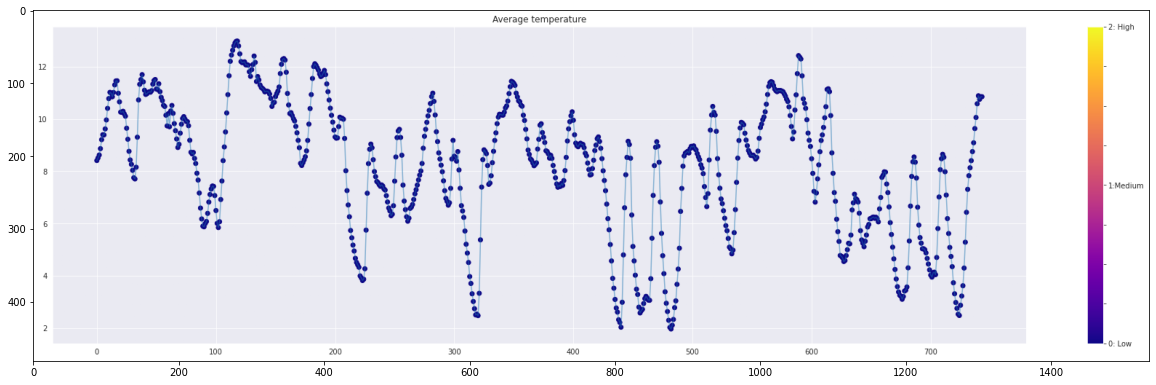

In [9]:
# Vizualisation of the results

plt.figure(figsize=(20, 8))
plt.plot(x, y, alpha=0.5)
plt.scatter(x, y, c = final_labels , cmap= "plasma", vmin=0, vmax=2)
bars = plt.colorbar()
plt.title('Average temperature')
bars.ax.set_yticklabels(['Low','','','','Medium','','','','High'])
plt.show()